## Effect of Magnetic Field

/tmp/ipykernel_9251/1013415898.py:17: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  for chunk in pd.read_csv(


Remaining galaxies after all cuts: 116978
0         186.973221
1         183.876816
2         183.820312
4         189.086685
5         187.996735
             ...    
144128    352.840000
144129    357.174000
144130      6.079566
144132    157.601672
144133    157.880328
Name: RA, Length: 116978, dtype: float64


/tmp/ipykernel_9251/1013415898.py:119: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  deflection_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)


<Figure size 1000x600 with 0 Axes>

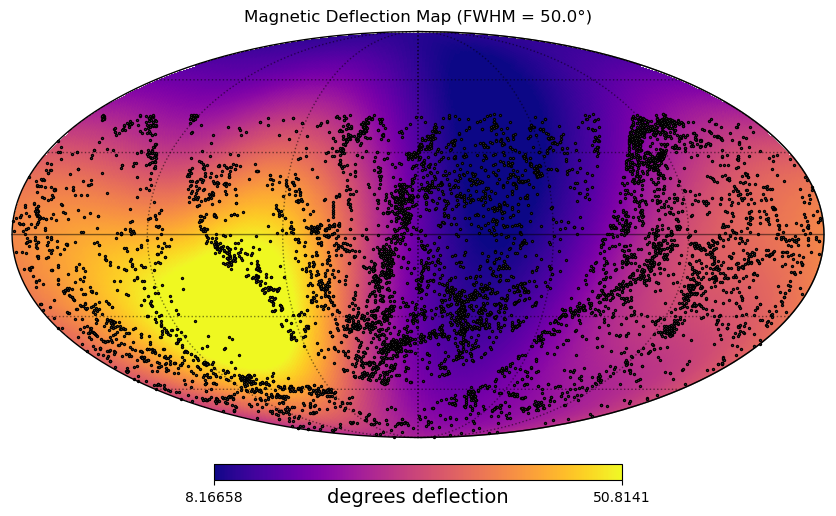

Median deflection = 24.248
High-deflection galaxies: 4033
Low-deflection galaxies:  4034
Randoms valid after deflection mask: 806700
High-deflection randoms: 532267
Low-deflection randoms:  274433


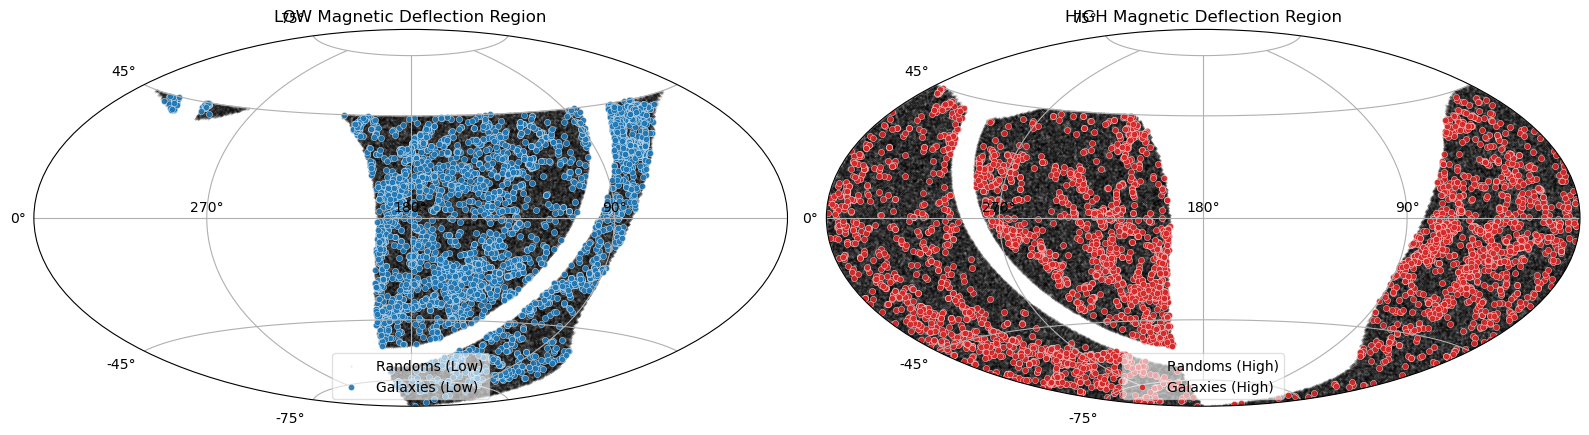

The following patch numbers have no objects: {257, 141, 94}
This may be a problem depending on your use case.
The following patch numbers have no objects: {94, 141, 6, 257}
This may be a problem depending on your use case.
The following patch numbers have no objects: {388, 350}
This may be a problem depending on your use case.
The following patch numbers have no objects: {388, 350}
This may be a problem depending on your use case.


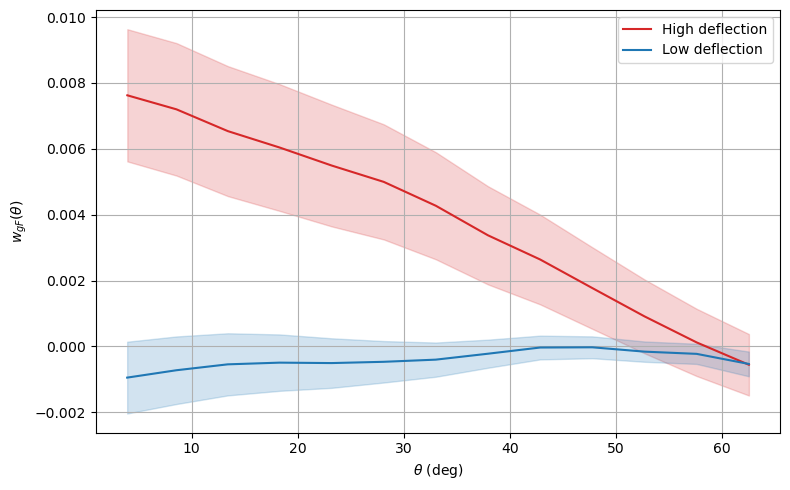

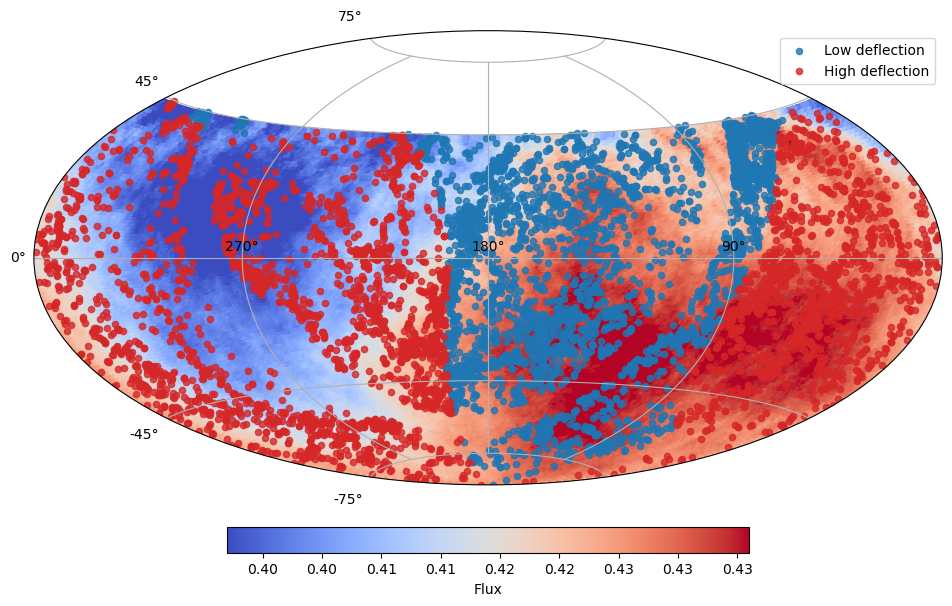

In [14]:
"""
GALAXY–FLUX CORRELATION SPLIT BY MAGNETIC DEFLECTION
"""
def read_GLADE(cols_to_use, cz_min=1200, dL_max=200):
    from get_masks import get_milkyway_mask

    filename = "../data/GLADE_zhelio_lt0.1_dL_lt300.txt"
    c = 299792.458  # km/s
    chunksize = 200_000

    # Read header
    with open(filename, 'r') as f:
        header = f.readline().lstrip('#').split()

    filtered_chunks = []

    for chunk in pd.read_csv(
        filename,
        delim_whitespace=True,
        names=header,
        usecols=cols_to_use,
        skiprows=1,
        chunksize=chunksize
    ):
        
        # Exclude entries with no redshift
        chunk = chunk[chunk["dist_flag"] != 0]

        # Compute cz
        chunk["cz"] = c * chunk["z_cmb"]

        # Apply the main physical filters
        chunk = chunk[(chunk["cz"] > cz_min) & (chunk["d_L"] < dL_max)]

        # Compute absolute K magnitude
        chunk["M_K"] = chunk["K"] - 5 * np.log10(chunk["d_L"]) - 25

        # Apply isfinite mask *inside the loop*
        mask = np.isfinite(chunk["M_K"]) & np.isfinite(chunk["d_L"])
        chunk = chunk.loc[mask]

        # Append filtered data
        filtered_chunks.append(chunk)

    # Concatenate everything
    df = pd.concat(filtered_chunks, ignore_index=True)
    # Compute absolute K magnitude
    df["M_K"] = df["K"] - 5 * np.log10(df["d_L"]) - 25

    df = df.iloc[get_milkyway_mask(df["RA"].values, df["Dec"].values)]
    df = df[df['Dec']<45.]

    print(f"Remaining galaxies after all cuts: {len(df)}")

    return df

def generate_RanCat(N_total, dec_min=-90, dec_max=45):
    from get_masks import get_milkyway_mask

    # Generate random RA and Dec within specified declination limits
    rand_ra = np.random.uniform(0, 360, N_total*3)
    rand_sindec = np.random.uniform(
        np.sin(np.radians(dec_min)), np.sin(np.radians(dec_max)), N_total*3
    )
    rand_dec = np.degrees(np.arcsin(rand_sindec))

    # Apply Milky Way mask
    mask = get_milkyway_mask(rand_ra, rand_dec)
    rand_ra = rand_ra[mask][:N_total]
    rand_dec = rand_dec[mask][:N_total]
    if len(rand_ra) < N_total:
        raise ValueError(f"Not enough random points generated: {len(rand_ra)} < {N_total}")

    return rand_ra, rand_dec

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.ticker import FormatStrFormatter
import treecorr
import healpy as hp
from astropy.io import ascii
import pandas as pd

# === User parameters ===
defl_file = "../data/JF12_GMFdeflection_Z1_E10EeV.csv"
fwhm_deg = 50.0
nrand = 100

# === Load Galaxies ===
cols = [
    "GLADE_no", "RA", "Dec", "z_cmb", "K", "d_L", "dist_flag"
]
gxs = read_GLADE(cols)
print(gxs['RA'])
if gxs['RA'].max() <= 2*np.pi:
    gxs['RA'] = np.degrees(gxs['RA'])
    gxs['Dec'] = np.degrees(gxs['Dec'])
    print("Converted RA/Dec from radians to degrees.")
gxs_K = gxs[(gxs['cz'] >= 1200) & (gxs['cz'] <= 4000)]  # cz cut

# === Load Flux map ===
file_path = "../data/Auger/flux_a8_lb.dat"
flux_cat = np.loadtxt(file_path)
flux_dec, flux_ra, flux_val = flux_cat[:, 0], flux_cat[:, 1], flux_cat[:, 2]

# === Load / prepare deflection map ===
data = ascii.read(defl_file)
pixel_ids = data['pixid']
deflection_data = data['deflection']
npix = int(np.max(pixel_ids)) + 1
nside = hp.npix2nside(npix)
deflection_map = np.full(npix, hp.UNSEEN)
deflection_map[pixel_ids] = deflection_data

# Smooth map
if fwhm_deg and fwhm_deg > 0:
    fwhm_rad = np.radians(fwhm_deg)
    deflection_map = hp.smoothing(deflection_map, fwhm=fwhm_rad, verbose=False)

# === Plot smoothed magnetic deflection map ===
plt.figure(figsize=(10, 6))
hp.mollview(
    deflection_map,
    title=f"Magnetic Deflection Map (FWHM = {fwhm_deg:.1f}°)",
    unit="degrees deflection",
    cmap="plasma",
    rot=(180, 0, 0),
    min=np.percentile(deflection_map[deflection_map != hp.UNSEEN], 5),
    max=np.percentile(deflection_map[deflection_map != hp.UNSEEN], 95),
)
hp.graticule(dpar=30, dmer=60, alpha=0.5)

# Optional: overlay galaxies as points
theta = -np.radians(90 - gxs_K["Dec"])
phi = np.radians(gxs_K["RA"]) + np.pi
hp.projscatter(theta, phi, lonlat=False, s=2, color="white", edgecolor='k', alpha=1)

plt.savefig("../plots/magnetic_deflection_map.png", dpi=300, bbox_inches="tight")
plt.show()

# === Assign each galaxy a deflection value ===
theta = np.radians(90 - gxs_K['Dec'])
phi = np.radians(gxs_K['RA'])
pix = hp.ang2pix(nside, theta, phi)
gal_defl = deflection_map[pix]

# Filter out unseen regions
valid = gal_defl != hp.UNSEEN
gxs_K = gxs_K[valid]
gal_defl = gal_defl[valid]

# === Classify galaxies by median deflection ===
median_defl = np.median(gal_defl)
#median_defl = np.percentile(gal_defl, 70)
mask_high = gal_defl > median_defl
mask_low = gal_defl <= median_defl

gxs_high = gxs_K[mask_high]
gxs_low = gxs_K[mask_low]

print(f"Median deflection = {median_defl:.3f}")
print(f"High-deflection galaxies: {len(gxs_high)}")
print(f"Low-deflection galaxies:  {len(gxs_low)}")

# === Apply deflection mask to the flux map, exactly like galaxies/randoms ===

# Convert flux RA/Dec to theta/phi
theta_f = np.radians(90 - flux_dec)
phi_f   = np.radians(flux_ra)
pix_f   = hp.ang2pix(nside, theta_f, phi_f)

# Read deflection at flux positions
flux_defl = deflection_map[pix_f]

# Keep only flux points in valid deflection region
valid_f = flux_defl != hp.UNSEEN

flux_dec = flux_dec[valid_f]
flux_ra  = flux_ra[valid_f]
flux_val = flux_val[valid_f]
flux_defl = flux_defl[valid_f]

# Split flux map into high/low using the SAME median from galaxies
mask_high_f = flux_defl > median_defl
mask_low_f  = flux_defl <= median_defl

flux_dec_high = flux_dec[mask_high_f]
flux_ra_high  = flux_ra[mask_high_f]
flux_val_high = flux_val[mask_high_f]

flux_dec_low  = flux_dec[mask_low_f]
flux_ra_low   = flux_ra[mask_low_f]
flux_val_low  = flux_val[mask_low_f]


# === Generate random catalog ===
rand_ra, rand_dec = generate_RanCat(len(gxs_K)*nrand, dec_min=-90, dec_max=45)

# === Apply the deflection mask to the randoms ===
theta_r = np.radians(90 - rand_dec)
phi_r = np.radians(rand_ra)
pix_r = hp.ang2pix(nside, theta_r, phi_r)

rand_defl = deflection_map[pix_r]
valid_r = rand_defl != hp.UNSEEN

# Keep only valid randoms
rand_ra = rand_ra[valid_r]
rand_dec = rand_dec[valid_r]
rand_defl = rand_defl[valid_r]

# Split randoms using galaxy median deflection
mask_high_r = rand_defl > median_defl
mask_low_r  = rand_defl <= median_defl

rand_ra_high  = rand_ra[mask_high_r]
rand_dec_high = rand_dec[mask_high_r]

rand_ra_low   = rand_ra[mask_low_r]
rand_dec_low  = rand_dec[mask_low_r]

print(f"Randoms valid after deflection mask: {len(rand_ra)}")
print(f"High-deflection randoms: {len(rand_ra_high)}")
print(f"Low-deflection randoms:  {len(rand_ra_low)}")

def plot_deflection_sky_panels(
    gxs_low, gxs_high,
    rand_ra_low, rand_dec_low,
    rand_ra_high, rand_dec_high,
    savepath=None
):
    """
    Make a 2-panel sky map (Hammer projection):
    Left:  low-deflection galaxies + randoms
    Right: high-deflection galaxies + randoms
    """

    import numpy as np
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(16, 7))

    # Common ticks
    xticks_deg = [270, 180, 90]
    xticks_rad = -np.radians(xticks_deg) + np.pi
    yticks_deg = [-75, -45, 0, 45, 75]
    yticks_rad = np.radians(yticks_deg)

    # -------------------------
    # Panel 1 — LOW deflection
    # -------------------------
    ax1 = fig.add_subplot(121, projection='hammer')
    ax1.grid(True)

    ax1.set_xticks(xticks_rad)
    ax1.set_xticklabels([f"{d}°" for d in xticks_deg])
    ax1.set_yticks(yticks_rad)
    ax1.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Randoms (light)
    ax1.scatter(
        np.deg2rad(-rand_ra_low + 180.), np.deg2rad(rand_dec_low),
        s=.1, color='black', alpha=0.15, label='Randoms (Low)'
    )

    # Galaxies
    ax1.scatter(
        np.deg2rad(-gxs_low['RA'] + 180.), np.deg2rad(gxs_low['Dec']),
        s=20, color='C0', edgecolor='white', linewidth=0.3,
        alpha=0.9, label='Galaxies (Low)'
    )

    ax1.set_title("LOW Magnetic Deflection Region")
    ax1.legend(loc="lower center", framealpha=0.6)


    # -------------------------
    # Panel 2 — HIGH deflection
    # -------------------------
    ax2 = fig.add_subplot(122, projection='hammer')
    ax2.grid(True)

    ax2.set_xticks(xticks_rad)
    ax2.set_xticklabels([f"{d}°" for d in xticks_deg])
    ax2.set_yticks(yticks_rad)
    ax2.set_yticklabels([f"{d}°" for d in yticks_deg])

    # Randoms (light)
    ax2.scatter(
        np.deg2rad(-rand_ra_high + 180.), np.deg2rad(rand_dec_high),
        s=.1, color='black', alpha=0.15, label='Randoms (High)'
    )

    # Galaxies
    ax2.scatter(
        np.deg2rad(-gxs_high['RA'] + 180.), np.deg2rad(gxs_high['Dec']),
        s=20, color='C3', edgecolor='white', linewidth=0.3,
        alpha=0.9, label='Galaxies (High)'
    )

    ax2.set_title("HIGH Magnetic Deflection Region")
    ax2.legend(loc="lower center", framealpha=0.6)


    plt.tight_layout()

    if savepath:
        plt.savefig(savepath, dpi=300, bbox_inches="tight")

    plt.show()

plot_deflection_sky_panels(
    gxs_low, gxs_high,
    rand_ra_low, rand_dec_low,
    rand_ra_high, rand_dec_high,
    savepath="../plots/sky_panels_deflection.png"
)

# === TreeCorr configuration ===
config = {
    "min_sep": 1,
    "max_sep": 65.,
    "nbins": 13,
    "sep_units": 'degree',
    "bin_type": 'Linear',
    "brute": False,
    "metric": 'Arc',
    "var_method": 'jackknife',
    "cross_patch_weight": 'geom'
}

# === Compute correlations for high and low deflection ===
def compute_corr(gxs_subset, rand_ra_subset, rand_dec_subset, \
                 flux_ra_subset, flux_dec_subset, flux_val_subset, \
                    label, color):
    gcat = treecorr.Catalog(
        ra=gxs_subset['RA'], dec=gxs_subset['Dec'],
        ra_units='deg', dec_units='deg', npatch=500
    )

    rand_cat = treecorr.Catalog(
        ra=rand_ra_subset, dec=rand_dec_subset,
        ra_units='deg', dec_units='deg',
        patch_centers=gcat.patch_centers
    )

    fcat = treecorr.Catalog(ra=flux_ra_subset, dec=flux_dec_subset, k=flux_val_subset,
                        ra_units='deg', dec_units='deg')

    nk = treecorr.NKCorrelation(config)
    rk = treecorr.NKCorrelation(config)

    nk.process(gcat, fcat)
    rk.process(rand_cat, fcat)

    xi = nk.xi / rk.xi - 1
    varxi = nk.varxi / (rk.xi ** 2)

    return nk.meanr, xi, varxi, label, color

results = []
results.append(compute_corr(
    gxs_high,
    rand_ra_high[:len(gxs_high)*nrand],
    rand_dec_high[:len(gxs_high)*nrand],
    flux_ra_high, flux_dec_high, flux_val_high,
    'High deflection', 'C3'
))

results.append(compute_corr(
    gxs_low,
    rand_ra_low[:len(gxs_low)*nrand],
    rand_dec_low[:len(gxs_low)*nrand],
    flux_ra_low, flux_dec_low, flux_val_low,
    'Low deflection', 'C0'
))



# === Plot correlation functions ===
plt.figure(figsize=(8, 5))
for meanr, xi, varxi, label, color in results:
    plt.fill_between(meanr, xi - np.sqrt(varxi), xi + np.sqrt(varxi),
                     color=color, alpha=0.2)
    plt.plot(meanr, xi, color=color, label=label)
plt.xlabel(r'$\theta$ (deg)')
plt.ylabel(r'$w_{gF}(\theta)$')
plt.grid()
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../plots/gal_flux_correlation_deflection.png', dpi=300)
plt.show()

# === Sky map with galaxies color-coded by deflection zone ===
plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='hammer')
ax.grid(True)

# Axes ticks
xticks_deg = [270, 180, 90]
xticks_rad = -np.radians(xticks_deg) + np.pi
ax.set_xticks(xticks_rad)
ax.set_xticklabels([f"{d}°" for d in xticks_deg])
yticks_deg = [-75, -45, 0, 45, 75]
yticks_rad = np.radians(yticks_deg)
ax.set_yticks(yticks_rad)
ax.set_yticklabels([f"{d}°" for d in yticks_deg])

# Background flux
norm_flux = mcolors.Normalize(vmin=np.percentile(flux_val, 5),
                              vmax=np.percentile(flux_val, 95))
sc = ax.scatter(np.deg2rad(-flux_ra + 180.), np.deg2rad(flux_dec),
                c=flux_val, s=20, cmap='coolwarm', norm=norm_flux, edgecolor='none', alpha=1)
cbar_flux = plt.colorbar(sc, ax=ax, orientation='horizontal', pad=0.08, fraction=0.05)
cbar_flux.set_label("Flux")
cbar_flux.ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

# Galaxies
ax.scatter(-gxs_low['RA'] + np.pi, gxs_low['Dec'],
           s=20, color='C0', label='Low deflection', alpha=0.8)
ax.scatter(-gxs_high['RA'] + np.pi, gxs_high['Dec'],
           s=20, color='C3', label='High deflection', alpha=0.8)

plt.legend()
plt.tight_layout()
plt.savefig('../plots/skymap_galaxies_deflection.png', dpi=300)
plt.show()
